In [4]:
import os
import sys
# ! git clone -b TF2.2.0_compatibility https://github.com/IgnacioAmat/Mask_RCNN.git
# ! cp -r /kaggle/input/mask-rcnn/Mask_RCNN/ .
mask_rcnn_path = '/kaggle/working/Mask_RCNN'
os.chdir(mask_rcnn_path)
sys.path.append(mask_rcnn_path)

# Training configuration

In [5]:
import os
import gc
import sys
import json
import glob
import random
from pathlib import Path

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import itertools
from tqdm import tqdm

from imgaug import augmenters as iaa
from sklearn.model_selection import StratifiedKFold, KFold
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
from PIL import Image, ImageDraw

NUM_CATS = 46
IMAGE_SIZE = 512
COCO_WEIGHTS_PATH = 'mask_rcnn_coco.h5'

class DeepFashionConfig(Config):
    NAME = "deepfashion"
    # +1 for the background class
    NUM_CLASSES = NUM_CATS + 1 
    
    GPU_COUNT = 1
    # a memory error occurs when IMAGES_PER_GPU is too high
    IMAGES_PER_GPU = 2 
    
    BACKBONE = 'resnet50'
    
    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE    
    IMAGE_RESIZE_MODE = 'none'
    
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    STEPS_PER_EPOCH = 1000
    VALIDATION_STEPS = 200

    USE_MINI_MASK=False
    
config = DeepFashionConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                59
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

# Dataset Generator

In [6]:
# create a dataset class for our custom data
class DeepFashionDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        # Add the class names using the base method from utils.Dataset
        source_name = "deepfashion"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                try:
                  image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                  image_annotations = annotations[image_id]
                  
                  # Add the image using the base method from utils.Dataset
                  self.add_image(
                      source=source_name,
                      image_id=image_id,
                      path=image_path,
                      width=image_width,
                      height=image_height,
                      annotations=image_annotations
                  )
                except KeyError as key1:
                  print('Id not found. Skipping')
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        # resize masks
        sub_mask = cv2.resize(np.float32(mask), (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST) \
                      .reshape(IMAGE_SIZE,IMAGE_SIZE,mask.shape[-1])

        class_ids = np.array(class_ids, dtype=np.int32)
        
        return sub_mask, class_ids

In [8]:
# images and annotations path
train_annotations = '/kaggle/input/deepfashion-data/train_annotation.json'
val_annotations = '/kaggle/input/deepfashion-data/val_annotation.json'
train_images = '/kaggle/input/deepfashion-data/train_images/'
val_images = '/kaggle/input/deepfashion-data/val_images/'

# load data
train_data = DeepFashionDataset()
train_data.load_data(train_annotations, train_images)
train_data.prepare()

val_data = DeepFashionDataset()
val_data.load_data(val_annotations, val_images)
val_data.prepare()

# View sample images and their masks

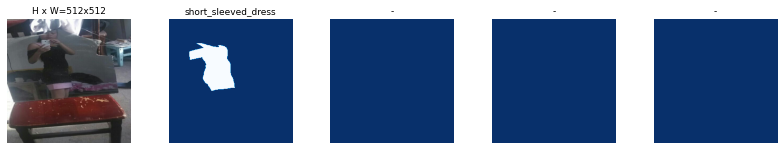

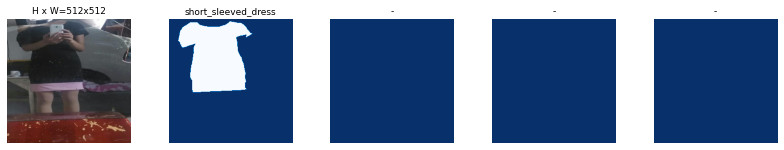

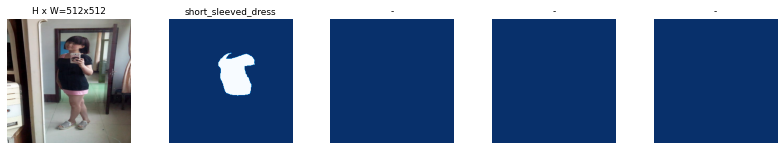

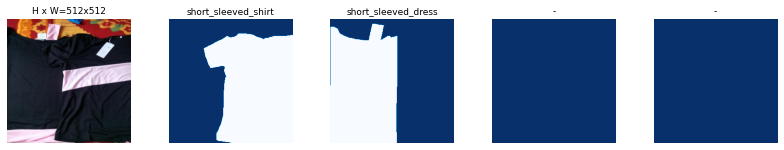

In [ ]:
for i in range(4):
    # random images
    image_id = random.choice(val_data.image_ids)
    print(val_data.image_reference(image_id))
    
    image = val_data.load_image(image_id)
    mask, class_ids = val_data.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, val_data.class_names, limit=4)

# Initialise model

In [9]:
MODEL_DIR = '/kaggle/working/Mask_RCNN/models_trained'
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    'mrcnn_class_logits', 'mrcnn_bbox_fc', 'mrcnn_bbox', 'mrcnn_mask'])

# TRAINING:-
### We apply Transfer learning where we use model pretrained on COCO dataset and freeze all layers except the final layer.

In [ ]:
%%time
import warnings
warnings.filterwarnings('ignore')

LR = 1e-2
# layers='heads' implies only train the final layer
model.train(train_data, val_data,
            learning_rate=LR,
            epochs=8,
            layers='heads',
            augmentation=None)

history = model.keras_model.history.history


Starting at epoch 0. LR=0.01

Checkpoint Path: /kaggle/working/Mask_RCNN/models_trained/deepfashion20210425T2008/mask_rcnn_deepfashion_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed

# Check model performance

In [9]:
import warnings
warnings.filterwarnings('ignore')

class InferenceConfig(DeepFashionConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

# trained model weights
model_weights = '/kaggle/input/deepfashion-data/mask_rcnn_fashion_0008.h5'

inference_config = InferenceConfig()

model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=os.getcwd())

# load trained model weights    
model.load_weights(filepath=model_weights,
                   by_name=True)

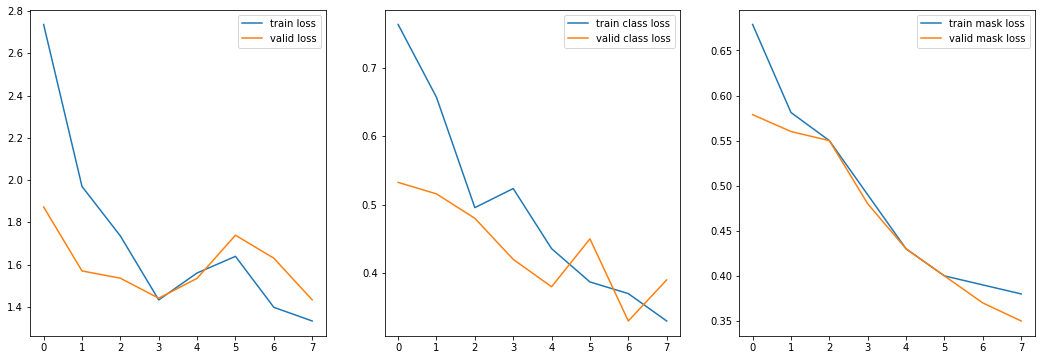

In [11]:
# model training history
history = model.keras_model.history.history
epochs = range(8)

plt.figure(figsize=(18, 6))

plt.subplot(131)
plt.plot(epochs, history['loss'], label="train loss")
plt.plot(epochs, history['val_loss'], label="valid loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, history['mrcnn_class_loss'], label="train class loss")
plt.plot(epochs, history['val_mrcnn_class_loss'], label="valid class loss")
plt.legend()
plt.subplot(133)
plt.plot(epochs, history['mrcnn_mask_loss'], label="train mask loss")
plt.plot(epochs, history['val_mrcnn_mask_loss'], label="valid mask loss")
plt.legend()

plt.show()

# Calculate mAP (mean Average Precision)

In [12]:
from mrcnn.model import load_image_gt, mold_image
from mrcnn.utils import compute_ap

# modify COCO evaluate function for our usecase
# ref: https://github.com/matterport/Mask_RCNN/blob/master/samples/coco/coco.py
def evaluate_model(dataset, model, cfg):
    list_avg_precision = []
    for image_id in dataset.image_ids:
        # get image data
        image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id)
        scaled_image = mold_image(image, cfg)
        sample = np.expand_dims(scaled_image, 0)

        # get detections
        yhat = model.detect(sample, verbose=0)
        r = yhat[0]
    
        # compute average precision
        avg_precision, precisions, recalls, overlaps = compute_ap(gt_bbox, gt_class_id, gt_mask, 
                                                              r["rois"], r["class_ids"], r["scores"], 
                                                              r['masks'], iou_threshold=0.5)

        list_avg_precision.append(avg_precision)

    mAP = np.mean(list_avg_precision)
    return mAP

In [13]:
# calculate train and validation mAP
train_mAP = evaluate_model(train_data, model, inference_config)
val_mAP = evaluate_model(val_data, model, inference_config)

### Test mAP

In [14]:
# test images and annotations path
test_annotations = '/kaggle/input/deepfashion-data/test_annotation.json'
test_images = '/kaggle/input/deepfashion-data/test_images/'

# load test data
test_data = DeepFashionDataset()
test_data.load_data(test_annotations, test_images)
test_data.prepare()

test_mAP = evaluate_model(test_data, model, inference_config)

# **RESULTS**

In [17]:
from prettytable import PrettyTable

table = PrettyTable()

table.title = 'mAP (Mean Average Precision)'
table.field_names = ['Data', 'mAP50']
table.add_row(['Train', train_mAP])
table.add_row(['Val', val_mAP])
table.add_row(['Test', test_mAP])

print(table)

+------------------------------+
| mAP (Mean Average Precision) |
+---------+--------------------+
|   Data  |       mAP50        |
+---------+--------------------+
|  Train  |    0.833762195     |
|   Val   |   0.74215243902    |
|   Test  |    0.7034878048    |
+---------+--------------------+


# INFERENCE

Image:/kaggle/input/deepfashion-data/test_demo_images/0002ec21ddb8477e98b2cbb87ea2e269.jpg


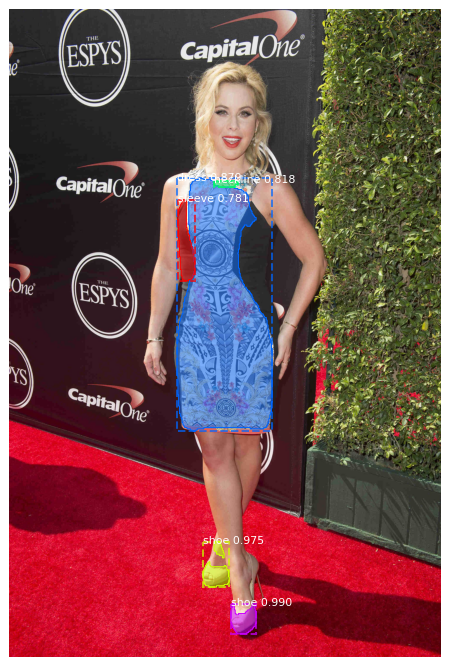

Image:/kaggle/input/deepfashion-data/test_demo_images/00211c06b1fe730097dde122cd4d3f8c.jpg


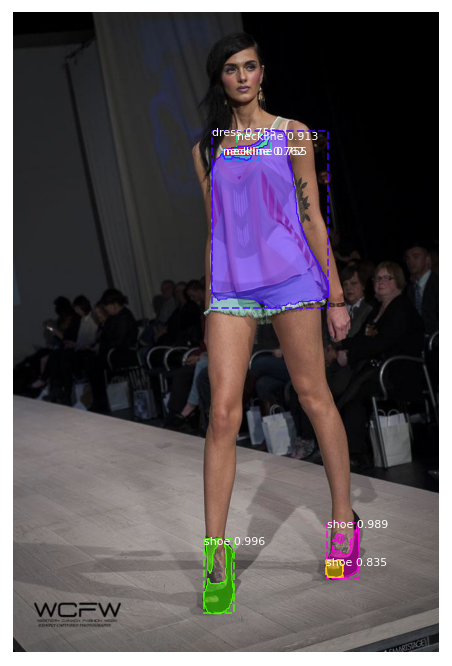

Image:/kaggle/input/deepfashion-data/test_demo_images/001d7807a696231045860eaee97e825b.jpg


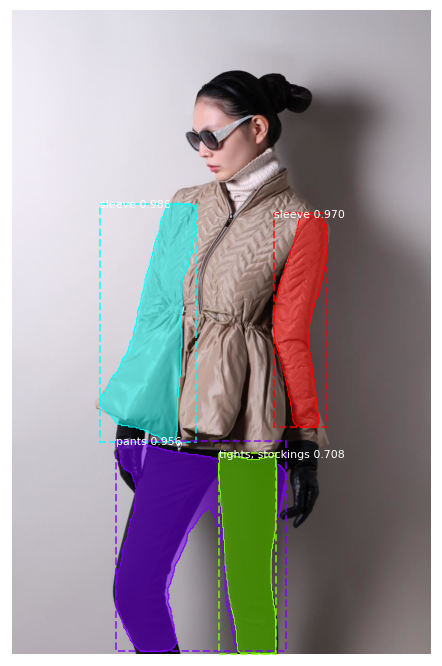

Image:/kaggle/input/deepfashion-data/test_demo_images/00048c3a2fb9c29340473c4cfc06424a.jpg


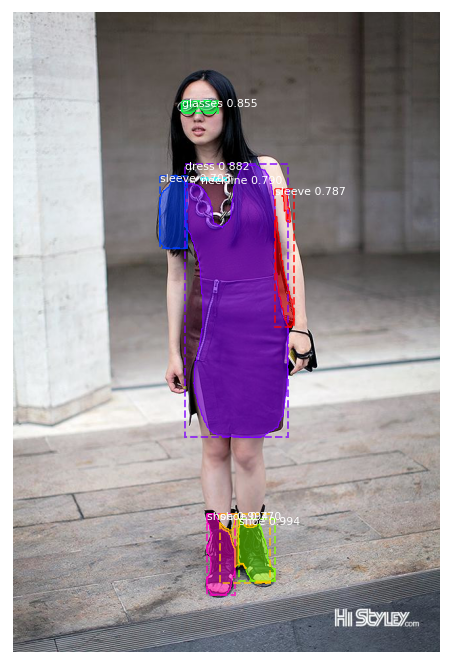

Image:/kaggle/input/deepfashion-data/test_demo_images/001657dc6f979869ebf38ea741e90675.jpg


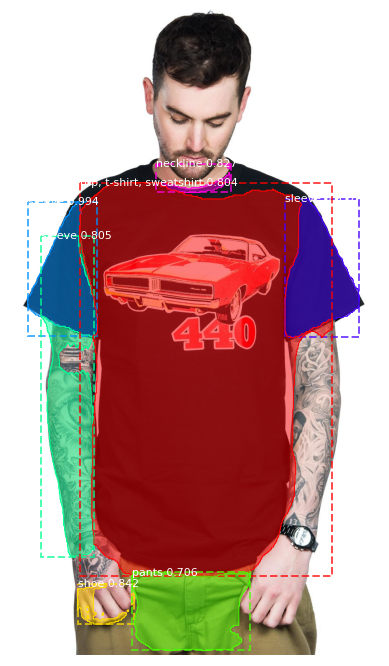

In [ ]:
import warnings
warnings.filterwarnings('ignore')

NUM_CATS = 46
IMAGE_SIZE = 512

def resize_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
    return img

def refine_masks(masks, rois):
    areas = np.sum(masks.reshape(-1, masks.shape[-1]), axis=0)
    mask_index = np.argsort(areas)
    union_mask = np.zeros(masks.shape[:-1], dtype=bool)
    for m in mask_index:
        masks[:, :, m] = np.logical_and(masks[:, :, m], np.logical_not(union_mask))
        union_mask = np.logical_or(masks[:, :, m], union_mask)
    for m in range(masks.shape[-1]):
        mask_pos = np.where(masks[:, :, m]==True)
        if np.any(mask_pos):
            y1, x1 = np.min(mask_pos, axis=1)
            y2, x2 = np.max(mask_pos, axis=1)
            rois[m, :] = [y1, x1, y2, x2]
    return masks, rois

class InferenceConfig(DeepFashionConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

model_weights = '/kaggle/input/deepfashion-data/mask_rcnn_fashion_0008.h5'

inference_config = InferenceConfig()

model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=os.getcwd())

# load trained model weights    
model.load_weights(filepath=model_weights,
                   by_name=True)

label_names = ['shirt, blouse','top, t-shirt, sweatshirt','sweater','cardigan',
 'jacket','vest','pants','shorts','skirt','coat','dress','jumpsuit','cape','glasses','hat',
 'headband, head covering, hair accessory','tie','glove', 'watch', 'belt', 'leg warmer', 'tights, stockings',
 'sock', 'shoe', 'bag, wallet', 'scarf', 'umbrella', 'hood', 'collar', 'lapel', 'epaulette', 'sleeve',
 'pocket', 'neckline', 'buckle', 'zipper', 'applique', 'bead', 'bow', 'flower', 'fringe', 'ribbon',
 'rivet', 'ruffle', 'sequin', 'tassel']

image_directory = '/kaggle/input/deepfashion-data/test_demo_images'#'myntra_scraped.png' #train_images+"/000011.jpg"  #"imat_test.jpg"
for images in os.listdir(image_directory):
    image_path = image_directory+os.sep+images
    img = cv2.imread(image_path)
    print(f'Image:{image_path}')
    # load the input image, convert it from BGR to RGB channel
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Perform a forward pass of the network to obtain the results
    r = model.detect([resize_image(image_path)], verbose=0)
    # Get the results for the first image.
    r = r[0]


    if r['masks'].size > 0:
        masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
        for m in range(r['masks'].shape[-1]):
            masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                        (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

        y_scale = img.shape[0]/IMAGE_SIZE
        x_scale = img.shape[1]/IMAGE_SIZE
        rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)

        masks, rois = refine_masks(masks, rois)
    else:
        masks, rois = r['masks'], r['rois']

    # display predictions
    visualize.display_instances(img, rois, 
                                masks, r['class_ids'], 
                                ['bg']+label_names, r['scores'],
                                figsize=(12, 12),show_mask=True)

# Separate the fashion items

In [ ]:
# combine subcategories
feet = ['shoe']
upperbody = ['cardigan','collar','hood','jacket','neckline','shirt, blouse','sleeve','sweater',
             'top, t-shirt, sweatshirt','vest',]
lowerbody = ['pants', 'pocket', 'shorts', 'skirt','stockings','tights', 'leg warmer']
wholebody = ['cape', 'coat', 'dress', 'jumpsuit','dress']

In [ ]:
# get bounding box predictions
def get_box(path):
    image_path = path
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=os.getcwd())
    result = model.detect([resize_image(image_path)])
    r = result[0]
    
    if r['masks'].size > 0:
        masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
        for m in range(r['masks'].shape[-1]):
            masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                      (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
      
        y_scale = img.shape[0]/IMAGE_SIZE
        x_scale = img.shape[1]/IMAGE_SIZE
        rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
      
        masks, rois = refine_masks(masks, rois)
        return img, masks, rois, r
    else:
        masks, rois = r['masks'], r['rois']
        return img,masks, rois, r

In [ ]:
# modify display_instances function to get all fashion items in an image
# https://github.com/matterport/Mask_RCNN/blob/master/mrcnn/visualize.py
def get_instances(image, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    masked_image = image.astype(np.uint32).copy()

    feet_temp = []
    upperbody_temp = []
    lowerbody_temp = []
    wholebody_temp = []

    for i in range(N):
        # Check bounding boxes
        if not np.any(boxes[i]):
            # Skip this instance if there is no bbox.
            continue
        y1, x1, y2, x2 = boxes[i]
        # Check Labels
        if not captions:
            class_id = class_ids[i]
            score = scores[i] if scores is not None else None
            label = class_names[class_id]
            caption = "{} {:.3f}".format(label, score) if score else label
            # confidence threshold
            if score>0.80:
                if label in feet:
                    feet_temp.append((y1, x1, y2, x2))
                if label in upperbody:
                    upperbody_temp.append((y1, x1, y2, x2))
                if label in lowerbody:
                    lowerbody_temp.append((y1, x1, y2, x2))
                if label in wholebody:
                    wholebody_temp.append((y1, x1, y2, x2))
        else:
            caption = captions[i]
    
    return  feet_temp ,upperbody_temp,lowerbody_temp , wholebody_temp

# crop otems from the bounding boxes
def crop(y1,x1,y2,x2,img):
    outimage = img[int(y1):int(y2), int(x1):int(x2)]
    return outimage

In [ ]:
# get pixel cordinates of each fashion item for cropping
def get_min_max(li,no,typee):
    mini = []
    for i in li:
        mini.append(i[no])
    if typee=='min': 
        return min(mini)
    if typee=='max':
        return max(mini)

# get cropped images
def get_crop_image(img,li,name):
    images = []
    if name=='feet':
        for i in li:
            outimage = crop(i[0],i[1],i[2],i[3],img)
            images.append(outimage)
    if name=='full':
        for i in li:
            outimage = crop(i[0],i[1],i[2],i[3],img)
            images.append(outimage)
    if name=='upp':
        y1 = get_min_max(li,0,'min')
        x1 = get_min_max(li,1,'min')
        y2 = get_min_max(li,2,'max')
        x2 = get_min_max(li,3,'max')
        outimage = crop(y1,x1,y2,x2,img)
        images.append(outimage)

    if name=='bott':
        y1 = get_min_max(li,0,'min')
        x1 = get_min_max(li,1,'min')
        y2 = get_min_max(li,2,'max')
        x2 = get_min_max(li,3,'max')
        images.append(outimage)
    return images

In [ ]:
def object_detctions(path):
    img , masks, rois, r = get_box(path)
    feet_temp ,upperbody_temp,lowerbody_temp , wholebody_temp = get_instances(img, rois, masks, r['class_ids'], 
                              ['bg']+label_names, r['scores'],
                              title=path, figsize=(12, 12),show_mask=False)
    feet_images = []
    whole_images = []
    upperbody_images = []
    lowerbody_images = []
    if len(feet_temp)>0:
        feet_images = get_crop_image(img,feet_temp,'feet')
    if len(wholebody_temp)>0:
        whole_images = get_crop_image(img,wholebody_temp,'full')
    if len(upperbody_temp)>0:
        upperbody_images = get_crop_image(img,upperbody_temp,'upp')
    if len(lowerbody_temp)>0:
        lowerbody_images = get_crop_image(img,lowerbody_temp,'bott')
  
    return img , masks, rois, r , feet_images, whole_images, upperbody_images, lowerbody_images

# Demo:-

## Prediction:

In [ ]:
path = '/kaggle/input/deepfashion-data/test_demo_images/00048c3a2fb9c29340473c4cfc06424a.jpg'
img , masks, rois, r , feet_images,whole_images,upperbody_images,lowerbody_images = object_detctions(path)

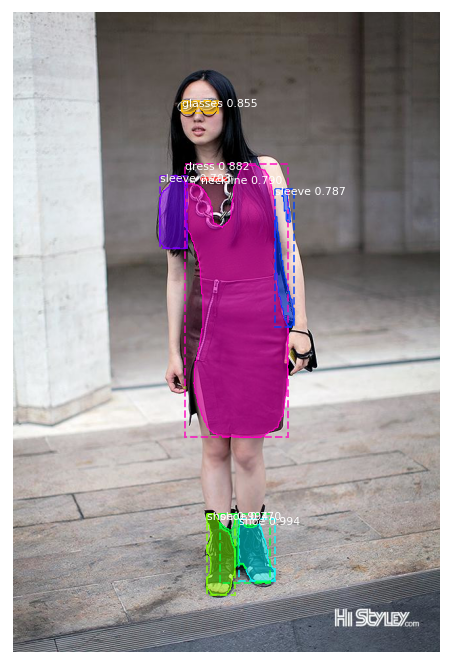

In [ ]:
# display predictions
visualize.display_instances(img, rois, 
                        masks, r['class_ids'], 
                        ['bg']+label_names, r['scores'],
                        figsize=(12, 12),show_mask=True)

# Fashion items:

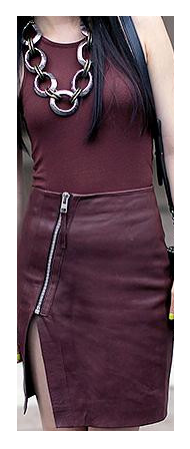

In [ ]:
for i in whole_images:
    outimage = i
    _, ax = plt.subplots(1, figsize=(8,8))
    auto_show = True

    height, width = outimage.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    img1 = outimage.astype(np.uint32).copy()
    ax.imshow(img1.astype(np.uint8))
    plt.show()

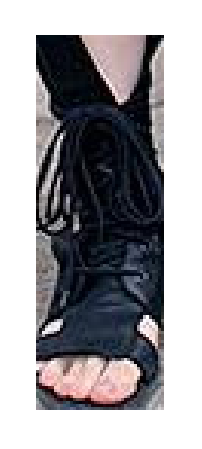

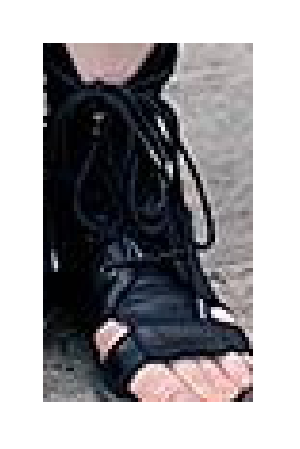

In [ ]:
for i in feet_images:
    outimage = i
    _, ax = plt.subplots(1, figsize=(8,8))
    auto_show = True

    height, width = outimage.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    img1 = outimage.astype(np.uint32).copy()
    ax.imshow(img1.astype(np.uint8))
    plt.show()